![crew](http://www.thenatterbox.com/wp-content/uploads/2016/11/futurama-couverture.png)

Welcome to my analysis of Futurama transcripts! For a long time Futurama has been one of my favorite shows and I've had the transcripts for the first 6 seasons for a while, so I thought it was well past time to take a look look at this data and do my first analysis of text data like this. 

Big thanks to Andrada for making [this](https://www.kaggle.com/andradaolteanu/sentiment-analysis-rick-and-morty-scripts#2.-Text-Mining) notebook as it was a big inspiration for me to work on this notebook! 

Then, the data used in this notebook can be found [here](https://www.kaggle.com/josephvm/futurama-seasons-16-transcripts). Big thanks to [https://theinfosphere.org/Episode_Transcript_Listing](https://theinfosphere.org/Episode_Transcript_Listing), where I originally scraped the data from. Of note, only the transcripts for the first 6 (of 7) seasons are used. I would like to get all the transcripts for season 7, but that will likely require watching the episodes and writing up the transcripts myself as I haven't been able to find most of them online. 

Now, let's get into it!

# Setup

In [1]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud, STOPWORDS
from nrclex import NRCLex
from PIL import Image

import nltk, os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline
plt.rcParams['font.size'] = 14

Let's take a quick look at our data. 

In [2]:
all_lines_df = pd.read_csv('only_spoken_text.csv')
all_lines_df.head()

,Season,Episode,Character,Line
0,1,Space Pilot 3000,Fry,Space. It seems to go on and on forever. But ...
1,1,Space Pilot 3000,Fry,And that's how you play the game!
2,1,Space Pilot 3000,Boy,"You stink, loser!"
3,1,Space Pilot 3000,Panucci,"Hey, Fry. Pizza goin' out! C'mon!!"
4,1,Space Pilot 3000,Fry,"Michelle, baby! Where you going?"


We should check if there's any missing data. 

In [3]:
all_lines_df.isna().sum()

Season       0
Episode      0
Character    0
Line         5
dtype: int64

Let's see what those lines look like. 

In [4]:
all_lines_df[all_lines_df['Line'].isna()]

,Season,Episode,Character,Line
2754,6,Fry Am the Egg Man,Man #1,NaN
19830,5,Bender's Game Part 1,ALL,NaN
20442,5,Bender's Game Part 4,ALL,NaN
22836,6,Lethal Inspection,Hermes,NaN
23485,6,The Prisoner of Benda,Bender,NaN


Being as we're largely looking at the lines themselves, may as well drop these lines. 

In [5]:
all_lines_df = all_lines_df.dropna(axis=0)
# all_lines_df['Line'] = all_lines_df['Line'].fillna('')

We'll add two more columns here to make some things cleaner later on. 

In [6]:
# Add some extra lines for ease of use later
all_lines_df['Num Chars'] = all_lines_df['Line'].apply(lambda x: len(x))
all_lines_df['Num Words'] = all_lines_df['Line'].apply(lambda x: len(x.split()))
all_lines_df.head(3)

,Season,Episode,Character,Line,Num Chars,Num Words
0,1,Space Pilot 3000,Fry,Space. It seems to go on and on forever. But ...,117,24
1,1,Space Pilot 3000,Fry,And that's how you play the game!,34,7
2,1,Space Pilot 3000,Boy,"You stink, loser!",18,3


Finally, we'll make all the text lowercase. 

In [7]:
all_lines_df['Line'] = all_lines_df['Line'].apply(lambda x: x.lower())

# Statistical

For the first part of the analysis, we'll look at a slew of statistics about it before we dive into the sentiment of the text. 

## 7 Characters With the Most Lines

First, quite simply, who are the 7 characters with the most lines?

In [8]:
top7 = all_lines_df['Character'].value_counts()[:7]
top7

Fry           3791
Bender        3395
Leela         2998
Farnsworth    1730
Zoidberg       888
Amy            863
Hermes         771
Name: Character, dtype: int64

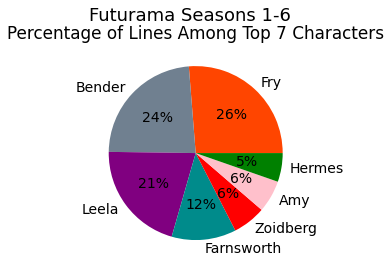

In [9]:
top_7_char_colors = ['orangered', 'slategrey', 'purple', 'darkcyan', 'red', 'pink', 'green']

plt.suptitle("Futurama Seasons 1-6", fontsize=18, y=1.01)
plt.title("Percentage of Lines Among Top 7 Characters")
plt.pie(top7, labels=top7.index, autopct='%1.f%%', 
        colors=top_7_char_colors, 
        );

plt.savefig('graphs/lines_top7.png', bbox_inches='tight')

Past the main crew of those 7, who's next on the list?

In [10]:
# Top 15 characters
pd.DataFrame(all_lines_df['Character'].value_counts()[:15])

,Character
Fry,3791
Bender,3395
Leela,2998
Farnsworth,1730
Zoidberg,888
Amy,863
Hermes,771
Zapp,482
Kif,249
Mom,174


After the 7 characters in nearly every episode, there's several recurring characters that often play big roles in the episodes that they are in. 

## Episode Appearances for the Crew

Let's take a quick look to see just how many episodes each member of the crew is in. 

In [11]:
# Number of episodes appeared in for each member of the crew
pd.DataFrame(all_lines_df.groupby('Character')['Episode'].nunique().sort_values(ascending=False).head(7))

,Episode
Character,
Bender,114
Leela,114
Fry,114
Farnsworth,112
Zoidberg,108
Hermes,105
Amy,101


In [12]:
# Number of episodes in this dataset
all_lines_df['Episode'].nunique()

114

It's not really surprising that the main trio of Fry, Leela, and Bender are in each episode. The rest of the crew, while not being in every episode, are still in most episodes, especially Professor Farnsworth. 

## Lines Per Episode

Next we'll analyze the number of lines per episodes, starting off with the episodes with the most and then the least lines. 

In [13]:
# 10 episodes with the most lines
pd.DataFrame(all_lines_df['Episode'].value_counts().head(10))

,Episode
The Problem with Popplers,272
Put Your Head on My Shoulders,266
Love's Labours Lost in Space,265
The Lesser of Two Evils,262
Bender Should Not Be Allowed on TV,261
Bender's Big Score Part 1,256
Fear of a Bot Planet,248
Where No Fan Has Gone Before,247
Bender Gets Made,245
Where the Buggalo Roam,244


In [14]:
# 10 episodes with the least lines
pd.DataFrame(all_lines_df['Episode'].value_counts().tail(10))[::-1]

,Episode
That Darn Katz!,165
A Taste of Freedom,166
The Honking,167
The Day the Earth Stood Stupid,169
Jurassic Bark,170
Obsoletely Fabulous,171
That's Lobstertainment!,171
Into the Wild Green Yonder Part 1,172
The Duh-Vinci Code,173
Godfellas,174


In [15]:
# Average lines per episode
all_lines_df['Episode'].value_counts().mean()

208.83333333333334

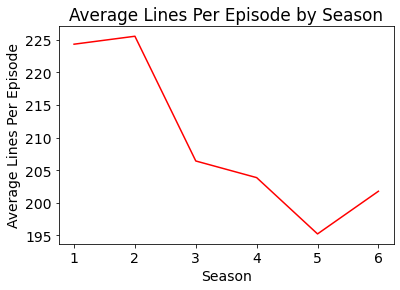

In [16]:
# Average lines per episode per season
fig, ax = plt.subplots()
lines_per_season = all_lines_df.groupby(['Season', 'Episode'])['Line'].count().groupby('Season').mean()
lines_per_season.plot(ax=ax, c='r')
plt.ylabel('Average Lines Per Episode')
plt.title('Average Lines Per Episode by Season');

Interesting how the average lines per episode per season goes down by almost 20 after the first two seasons and stays lower. Let's see if the lines are getting longer then. 

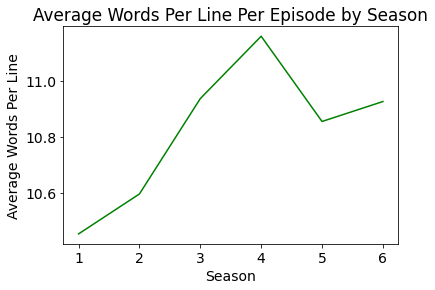

In [17]:
# Average words per line per episode
fig, ax = plt.subplots()
avg_words_per_line_per_season = all_lines_df.groupby(['Season', 'Episode'])['Num Words'].mean().groupby('Season').mean()
avg_words_per_line_per_season.plot(ax=ax, c='g')
plt.ylabel('Average Words Per Line')
plt.title('Average Words Per Line Per Episode by Season');

Season 3 certainly sees an uptick in average words per line, so maybe that partially accounts for the drop in lines per episode seen at that point. 

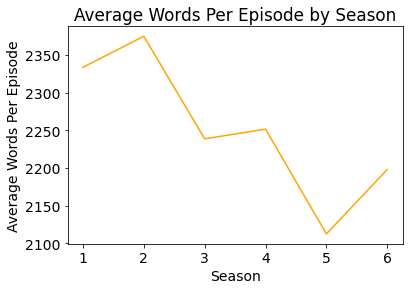

In [18]:
fig, ax = plt.subplots()
avg_words_per_season = all_lines_df.groupby(['Season', 'Episode'])['Num Words'].sum().groupby('Season').mean()
avg_words_per_season.plot(ax=ax, c='orange')
plt.ylabel('Average Words Per Episode')
plt.title('Average Words Per Episode by Season');

As suspected, the average words per line going up isn't enough to completely account for the drop in lines per episode. The average words per episode still goes down after season 2 by about 100 words and it never comes close to that same peak. 

## Number of Characters Per Episode

Here we'll look at the 5 episodes with the most characters and the 5 with the fewest. 

In [19]:
# 5 episodes with the most characters with a line and 5 with the fewest
num_char_episode = all_lines_df.groupby('Episode')['Character'].nunique().sort_values(ascending=False)
pd.DataFrame(num_char_episode)

,Character
Episode,
The Beast with a Billion Backs Part 1,63
Into the Wild Green Yonder Part 4,55
The Beast with a Billion Backs Part 3,53
The Beast with a Billion Backs Part 2,52
Bender's Game Part 4,51
...,...
I Second That Emotion,16
The Duh-Vinci Code,16
"Brannigan, Begin Again",16


## Average Lines Per Character Per Episode

Similarly to the previous part, we'll look at the average number of lines per character per episode now. 

It makes sense that there's three episodes from the 5 episodes with the fewest characters that now appear in the top 5 for average lines per character. Similarly for the most characters and least average lines per character. 

In [20]:
# 5 episodes with the most and 5 with the fewest lines per character
avg_char_lines = all_lines_df['Episode'].value_counts() / num_char_episode
pd.DataFrame(avg_char_lines.sort_values(ascending=False), columns=['Lines'])

,Lines
Love's Labours Lost in Space,15.588235
The Deep South,15.142857
I Second That Emotion,14.625000
"Brannigan, Begin Again",14.500000
The Route of All Evil,14.250000
...,...
Into the Wild Green Yonder Part 4,3.836364
The Beast with a Billion Backs Part 2,3.538462
The Beast with a Billion Backs Part 3,3.509434
Bender's Game Part 4,3.450980


Let's plot average lines per character against characters per episode to see if there is a real trend here. 

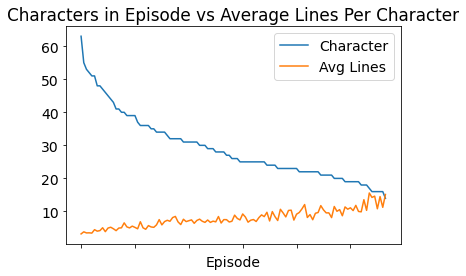

In [21]:
# Plot those two stats against each other
characters_avg_lines_df = pd.DataFrame(num_char_episode) 
characters_avg_lines_df['Avg Lines'] = pd.DataFrame(avg_char_lines, columns=['Lines'])['Lines']
fig, ax = plt.subplots()
characters_avg_lines_df.plot(ax=ax)
ax.set_title('Characters in Episode vs Average Lines Per Character')
ax.set_xticklabels([]);

## Average Length of Lines

The last thing we'll look at before digging into the sentiment of the text is the average length of lines by character.

* Num Words is the average number of words per line
* Num Chars is the average number of characters per line
* Avg Word Length is the average word length by number of characters in it

In [22]:
# Character's average number of words per line, number of characters per line, and average characters per word
top_seven_df = all_lines_df[all_lines_df['Character'].isin(top7.index.tolist())]
avg_word_line = top_seven_df.groupby('Character')[['Num Words', 'Num Chars']].mean().sort_values(by='Num Words', ascending=False)
avg_word_line['Avg Word Length'] = avg_word_line['Num Chars'] / avg_word_line['Num Words']
avg_word_line

,Num Words,Num Chars,Avg Word Length
Character,,,
Farnsworth,13.348555,75.076301,5.624302
Bender,10.561708,56.934021,5.390607
Leela,10.167111,54.881588,5.397953
Hermes,10.114137,55.927367,5.529623
Zoidberg,9.826577,53.599099,5.454504
Fry,9.784490,52.196782,5.334645
Amy,7.712630,42.399768,5.497446


We can see that not only are Professor Farnsworth's lines the longest by number of words for the crew by a decent margin, but he also tends to use longer words on average. Fry meanwhile uses the shortest words (which is especially impressive given that other characters get to say his short 3-letter name frequently). 

Overall, these are the marks for average number of words and characters per line, surprisingly high given what we've seen from the crew. 

In [23]:
# Average number of words and average number of characters per line
all_lines_df['Num Words'].mean(), all_lines_df['Num Chars'].mean()

(10.77863653547276, 59.08757928340404)

# Sentiment Analysis

It's time to dig into some sentiment analysis! We'll start with positive vs negative and then we'll do some NRC Emotion analysis. 

## Positive vs Negative

For the positive vs negative sentiment analysis, I've used NLTK. NLTK's sentiment analysis uses VADER, which seems to use a list of words with a sentiment rating associated with each word to sum up the total positive sentiment and negative sentiment based on the words found in the text and their associated rating. More info can be found 
[here](https://investigate.ai/investigating-sentiment-analysis/comparing-sentiment-analysis-tools/) (as well as a helpful reference). 

In [24]:
# Combine all the lines
all_text = ""
for i, row in all_lines_df.iterrows():
    all_text = all_text + row['Line'] + ' '

In [25]:
pos_neg_sentiment = {}

top7_joined_lines = all_lines_df.groupby('Character').apply(lambda x: " ".join(x['Line']))[top7.index]

sia = SIA()

# Get overall sentiment
pos_neg_sentiment['Overall'] = sia.polarity_scores(all_text)

# Get sentiment for each character
for character in top7_joined_lines.index:
    pos_neg_sentiment[character] = sia.polarity_scores(top7_joined_lines[character])
    
pn_sentiment = pd.DataFrame(pos_neg_sentiment).T
pn_sentiment.columns = ['Negative', 'Neutral', 'Positive', 'Compound']
pn_sentiment[['Positive', 'Negative', 'Neutral']].sort_values(by='Positive', ascending=False)

,Positive,Negative,Neutral
Amy,0.195,0.110,0.694
Zoidberg,0.186,0.142,0.672
Bender,0.184,0.136,0.680
Fry,0.179,0.118,0.703
Overall,0.174,0.125,0.701
Hermes,0.166,0.113,0.721
Leela,0.164,0.127,0.709
Farnsworth,0.135,0.149,0.716


Sorted by positive sentiment, we can see that there's a noticeable gap between Amy and Professor Farnsworth for positive sentiment, while the gap between the highest and lowest for negative sentiment seems to be a bit over half the size (between the same two characters). Overall all characters are fairly neutral as well. 

## NRC Emotion Analysis

Next up is the NRC Emotion Analysis. This analysis was done with the help of the [NRCLex library](https://pypi.org/project/NRCLex/). Emotional affect is measured for 8 different emotions, along with positive and negative. Those 8 emotions are:
* Anger
* Anticipation
* Disgust
* Fear
* Joy
* Sadness
* Surprise
* Trust

### The Crew

First we'll look at these emotions for the crew. 

In [26]:
top7_nrc_dict = {}

# Get the emotion frequencies for the Crew
for character in top7_joined_lines.index:
    text_object = NRCLex(top7_joined_lines[character])
    top7_nrc_dict[character] = text_object.affect_frequencies

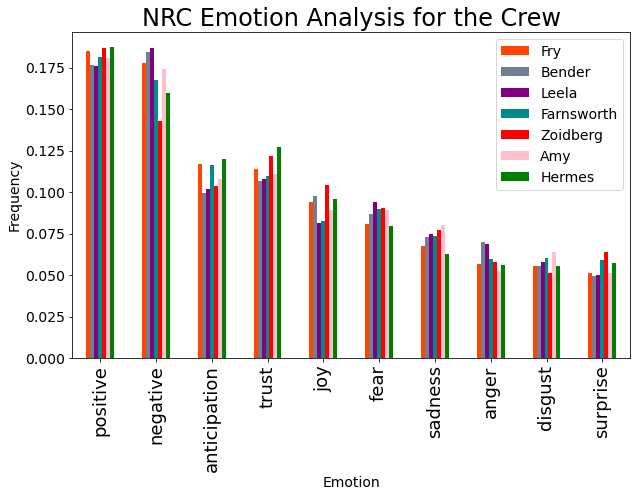

In [27]:
# Plot it
fig, ax = plt.subplots(figsize=(10,6))
plt.title('NRC Emotion Analysis for the Crew', size=24)
plt.xlabel('Emotion')
plt.ylabel('Frequency')
ax.tick_params(axis='x', labelsize=18)
nrc_df = pd.DataFrame(top7_nrc_dict).drop(['anticip'], axis=0).sort_values(by='Fry', ascending=False)
nrc_df.plot.bar(ax=ax, color=top_7_char_colors);

For the most part, each of these 7 characters seem to follow the same general trend. A few interesting things are how much less joy Leela and Professor Farnsworth express and Dr. Zoidberg expressing the most surprise of the crew. 

### By Episode

Next we'll take a look at the emotion on a per-episode basis. 

In [28]:
# join lines for each episode
episode_joined_lines = all_lines_df.groupby('Episode').apply(lambda x: " ".join(x['Line']))
episode_nrc_dict = {}

# get affect frequencies
for episode in episode_joined_lines.index:
    text_object = NRCLex(episode_joined_lines[episode])
    episode_nrc_dict[episode] = text_object.affect_frequencies

In [29]:
episode_nrc_df = pd.DataFrame(episode_nrc_dict).T

episode_top_bot_df = pd.DataFrame()
for col in episode_nrc_df:
    if col == 'anticip':
        continue
#     print(col.upper())
#     print(episode_nrc_df.sort_values(by=col, ascending=False).head()[col])
#     print('***')
#     print('***') 
    
    # top 5
    temp_top = episode_nrc_df.sort_values(by=col, ascending=False).head()[col]
    for row in temp_top.index:
        episode_top_bot_df = episode_top_bot_df.append(pd.Series([col, 'Top', row, temp_top[row]]), ignore_index=True)
    
    # bottom 5
    temp_bot = episode_nrc_df.sort_values(by=col, ascending=False).tail()[col]
    for row in temp_bot.index:
        episode_top_bot_df = episode_top_bot_df.append(pd.Series([col, 'Bottom', row, temp_bot[row]]), ignore_index=True)

In [30]:
episode_top_bot_df.columns = ['Emotion', 'Placement', 'Episode', 'Value']
episode_top_bot_df = episode_top_bot_df.set_index(['Emotion', 'Placement', 'Episode'])
episode_top_bot_df

Value
Emotion      Placement Episode                          
fear         Top       The Tip of the Zoidberg  0.141689
                       Bender's Game Part 4     0.126456
                       Lethal Inspection        0.126456
                       Ghost in the Machines    0.123037
                       Rebirth                  0.122222
...                                                  ...
anticipation Bottom    Bendless Love            0.074257
                       Leela's Homeworld        0.074004
                       Hell Is Other Robots     0.072359
                       The Tip of the Zoidberg  0.069482
                       The Honking              0.068047

[100 rows x 1 columns]

The following 10 graphs show both the top 5 and the bottom 5 episodes for a specific emotion, along with a dividing line to separate them. 

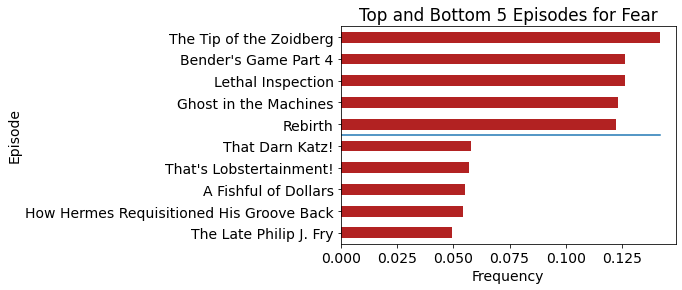

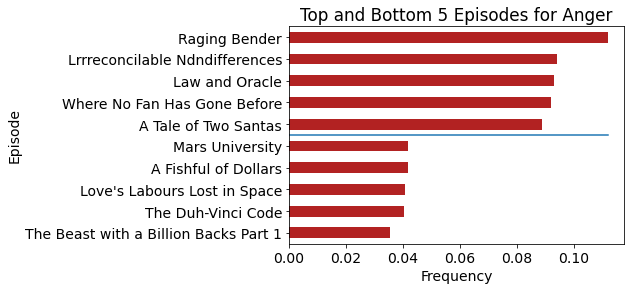

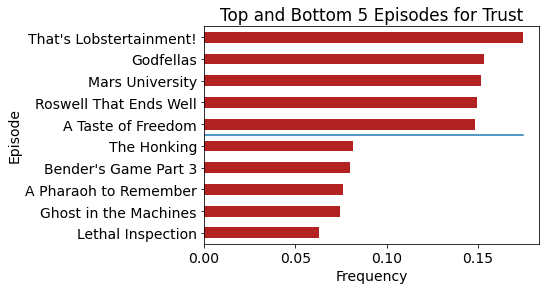

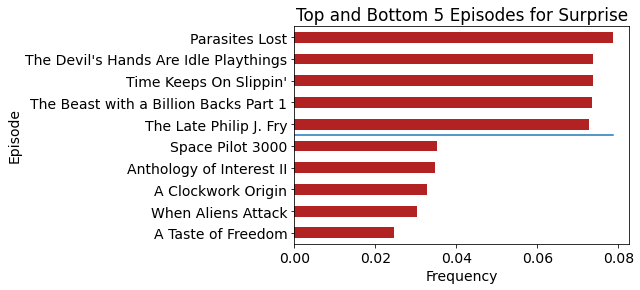

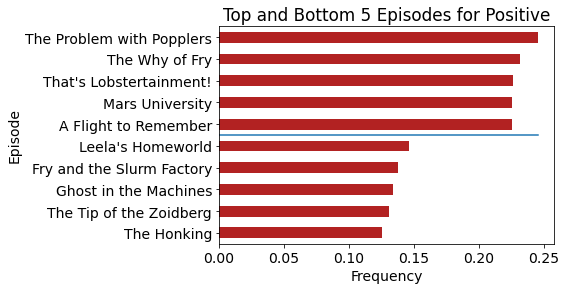

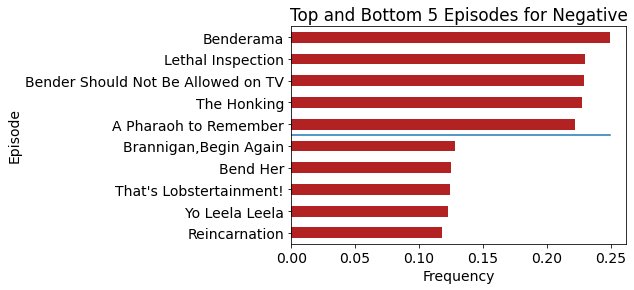

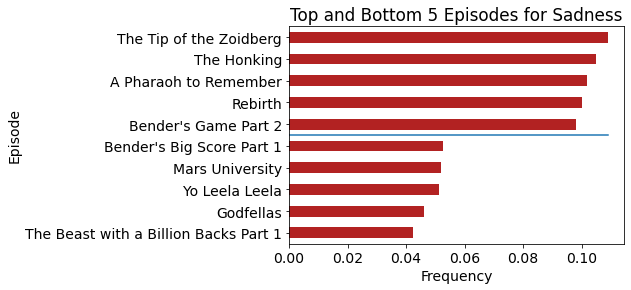

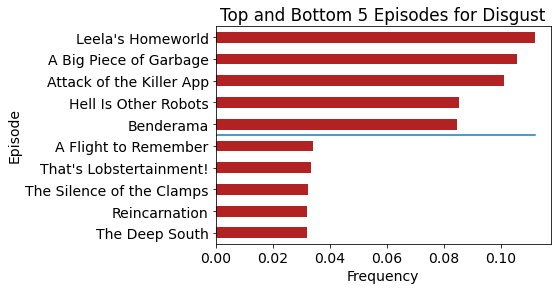

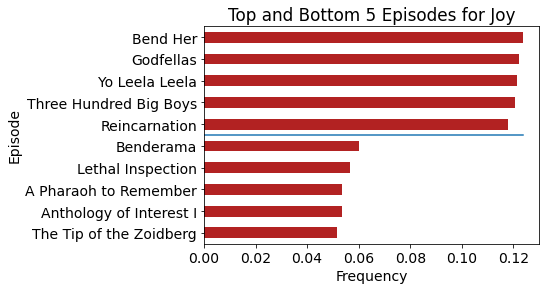

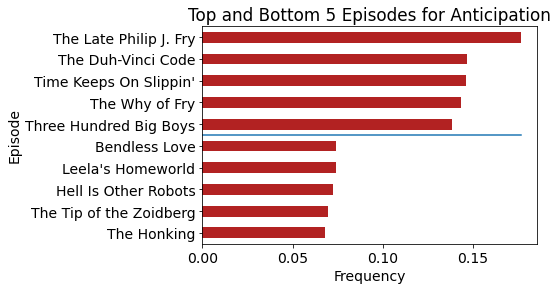

In [31]:
# Plots the top 5 and bottom 5 episodes for a specific emotion
# Provides a dividing line
def get_emotion_bar(emotion):
    fig, ax = plt.subplots()
    episode_top_bot_df.loc[emotion][::-1].plot.barh(ax=ax, legend=False, color='firebrick')
    ax.set_yticklabels([','.join([yy.strip() for yy in y.get_text().split(',')[1:]])[:-1] for y in ax.get_yticklabels()])
    ax.set_title('Top and Bottom 5 Episodes for {}'.format(emotion.title()))
    ax.set_ylabel('Episode')
    ax.set_xlabel('Frequency')
    ax.plot([0, episode_top_bot_df.loc[emotion].iloc[0]['Value']], [4.5, 4.5])
    return ax

# For each emotion, plot it
for emotion in [y for y in episode_nrc_df.columns.tolist() if y != 'anticip']:
    get_emotion_bar(emotion)

There's two surprising things for me looking at these graphs. 
* The first is that three of the best episodes (in my opinion but also in a general opinion from what I've seen) are in the top 5 for surprise (Parasites Lost, The Devil's Hands Are Idle Playthings, and The Late Philip J. Fry). 
* Another is the abscence of some of the notoriously sad episodes in the top 5 for sadness, like Jurassic Bark. Maybe the sadness from that episode isn't conveyed in the dialogue as much as it is in other elements. 

# Miscellaneous

## Word Clouds

Now we'll look at some word clouds to see the most frequently used words in the show. The wordcloud library is used, found [here](https://amueller.github.io/word_cloud/auto_examples/masked.html#sphx-glr-auto-examples-masked-py).

In [32]:
stopwords = set(STOPWORDS)

# Gets mask for a given character
def get_mask(character):
    char_mask = np.array(Image.open(os.path.join('images', 'masks', '{}_mask.jpg'.format(character))))

    # force values to 0 or 255
    char_mask[char_mask < 200] = 0
    char_mask[char_mask >= 200] = 255
    return char_mask

### Overall

First is a word cloud for all the text in the show. 

In [33]:
# Make the WordCloud object
wc = WordCloud(background_color="white", max_words=500,
               stopwords=stopwords, contour_width=3, contour_color='slategrey', 
               width=1600, height=800)

# Generate word cloud
wc.generate(all_text)

# Save it
wc.to_file(os.path.join('images', 'clouds', 'overall_cloud.png'));

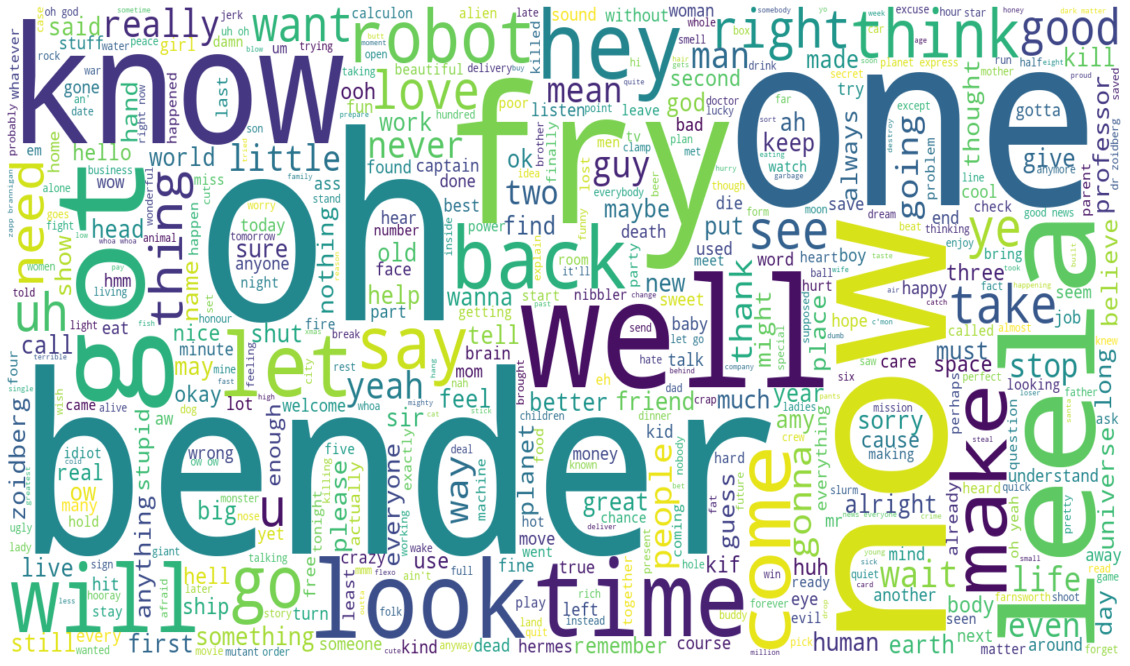

In [34]:
# Display it
plt.figure(figsize=(20, 12))
plt.imshow(wc, interpolation='bilinear', aspect='auto')
plt.axis("off");

### The Crew

Now we have a separate word cloud for each of the members of the crew.

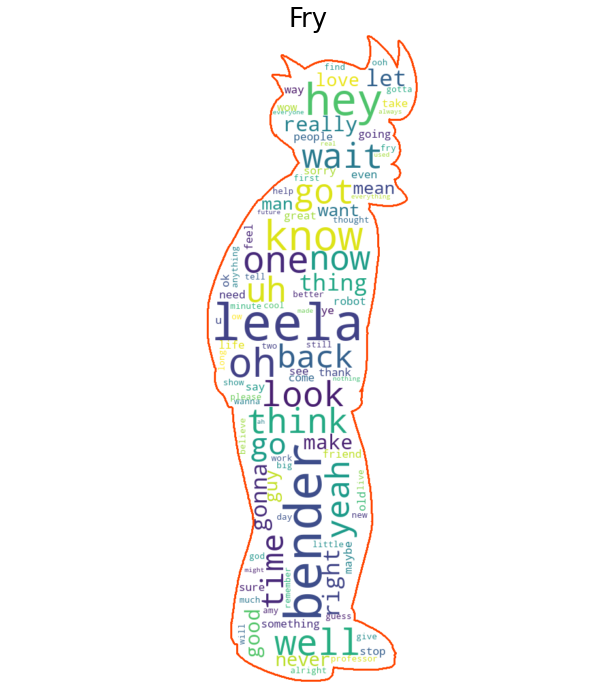

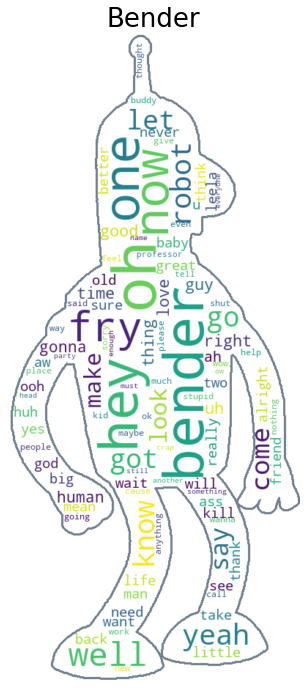

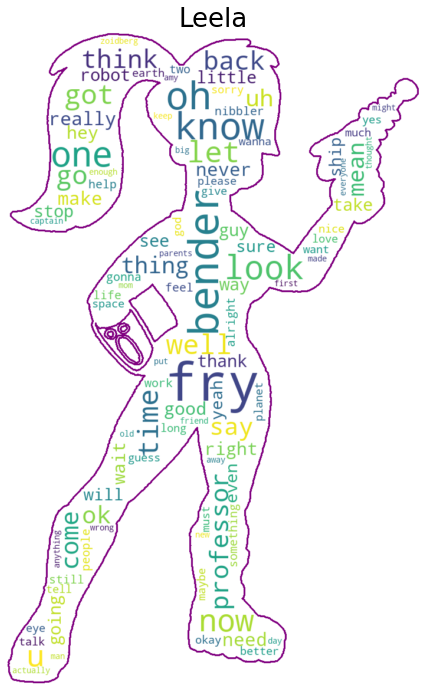

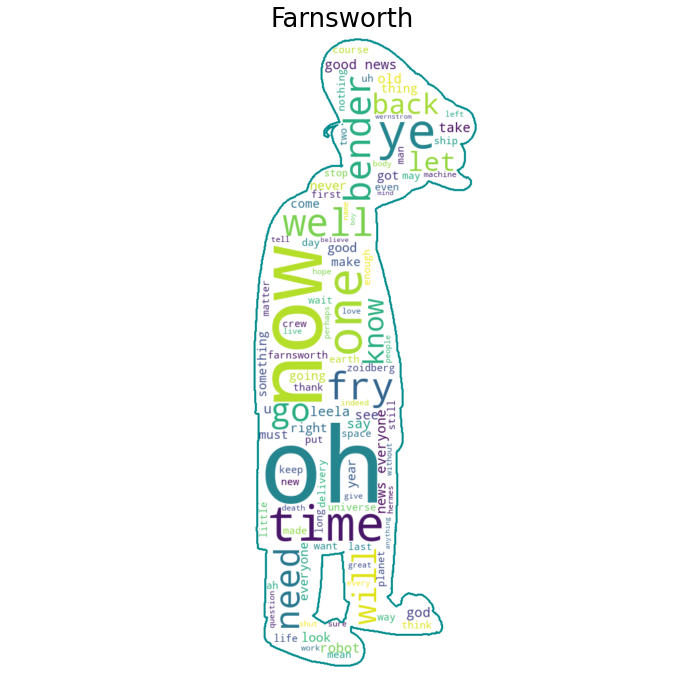

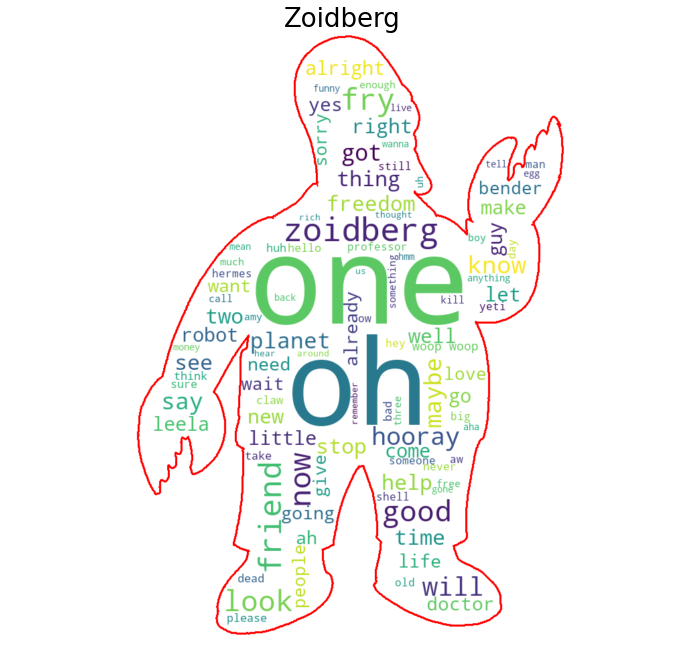

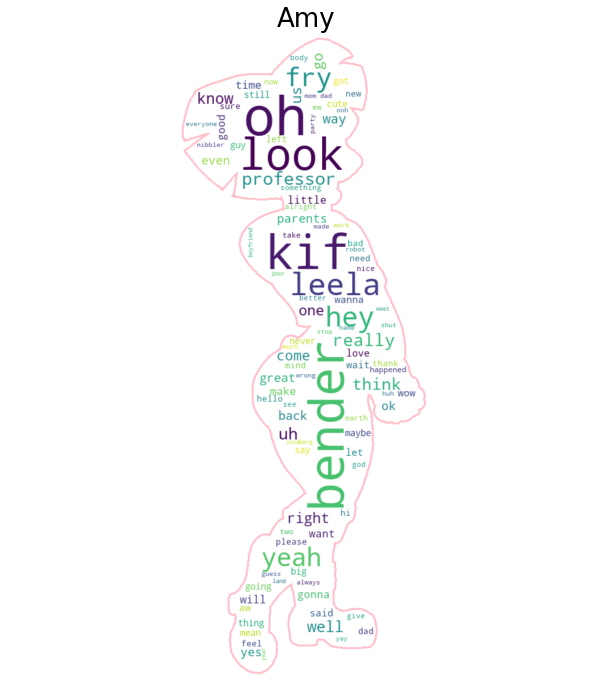

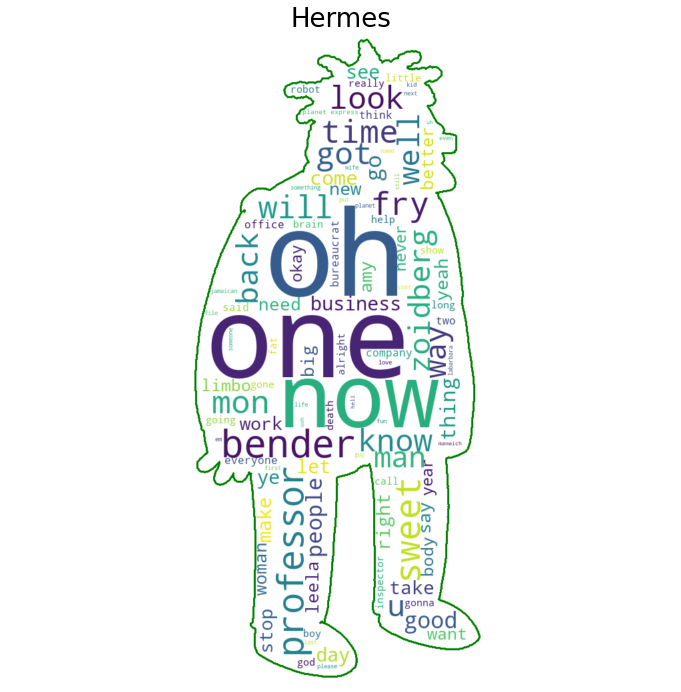

In [35]:
# Outline sources
# https://www.drawinghowtodraw.com/stepbystepdrawinglessons/2012/02/how-to-bender-from-futurama-with-easy-step-by-step-drawing-tutorial/
# https://www.drawingforall.net/how-to-draw-dr-zoidberg-from-futurama/
# https://www.drawingforall.net/how-to-draw-fry-from-futurama/
# https://www.drawingforall.net/how-to-draw-how-amy-wong-from-futurama/
# https://www.drawingforall.net/how-to-draw-hermes-conrad/
# https://www.pinterest.com/pin/797137202764876557/ - Leela
# https://www.drawingforall.net/how-to-draw-hubert-farnsworth/

for i in range(len(top7_joined_lines.index.tolist())):
    char_color = top_7_char_colors[i]
    character = top7_joined_lines.index[i]
    
    wc = WordCloud(background_color="white", max_words=100, mask=get_mask(character), 
                   stopwords=stopwords, contour_width=3, contour_color=char_color, 
                   width=100, height=300)

    # Generate word cloud
    text = top7_joined_lines[character]
    wc.generate(text)
    
    # Save it
    wc.to_file(os.path.join('images', 'clouds', '{}_cloud.png'.format(character)))

    # Display
    plt.figure(figsize=(12,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(character, size=26)
    plt.show()

## Fictional Events

As most of Futurama takes place 1000 years in the future, on occasion a character will mention some event that happens in the past. Here, we'll try and find them all. 

In [57]:
# Fictional events

year_lines = all_lines_df[all_lines_df['Line'].str.contains('\d\d\d\d', regex=True)]
for i, row in year_lines.iterrows():
    pass
#     print(i)
#     print(row['Line'])
#     print('*****************')
year_lines.shape

(120, 6)

Commented out now, but I went through them myself to pick the lines that we're looking for. 

In [58]:
picked_years_index = [79, 464, 2446, 3246, 3722, 3835, 4800, 4889, 6411, 6488, 
                      11664, 14925, 15539, 19497, 19508, 20656, 21783]

picked_year_lines = year_lines.loc[picked_years_index].drop(['Num Chars', 'Num Words'], axis=1)
for val in picked_year_lines['Line']:
    pass
#     print(val)
#     print('*************')

picked_year_lines

,Season,Episode,Character,Line
79,1,Space Pilot 3000,Booth Voice,you are now dead. thank you for using stop-n-...
464,6,The Mutants Are Revolting,Mrs. Astor,"on april 10, 2912, my late husband and i set ..."
2446,1,Mars University,Farnsworth,"well, in those days mars was just a dreary, u..."
3246,6,Cold Warriors,Leela,hmmm. all ancient satellites were swept up as...
3722,1,When Aliens Attack,Leela,"they are now. in the 2600's, new yorkers elec..."
3835,1,When Aliens Attack,Farnsworth,"no, there wouldn't be. most videotapes from t..."
4800,2,Xmas Story,O'Brien,"listen, pal, i may have lost my freakishly lo..."
4889,2,Xmas Story,Farnsworth,"back in 2801, the friendly robot company buil..."
6411,2,A Clone of My Own,Leela,hubert j. farnsworth was born april 9th 2851 ...
6488,2,A Clone of My Own,Farnsworth,of course not. that's why scientists increase...


Manually cleaning and ordering them, here is the result. 

2000 - New York City, under cover of darkness, put its garbage out to sea on the world's largest barge. The repulsive barge circled the oceans for 50 years. Finally, in 2052, the city used its mob connections to obtain a rocket and launch the garbage into outer space. 
*************
2008 - Stop-n-Drop becomes America's favourite suicide booth
*************
2012 - War of 2012 
*************
2038 - Petroleum reserves ran dry
*************
Since 2063 - we simply drop a giant ice cube into the ocean every now and then.
*************
2113 - All ancient satellites were swept up as space junk
*************
2200's - The anchovy went extinct
*************
2208 - Scientists increased the speed of light
*************
2275 - The Fairness in Hell act of 2275 is passed
*************
2443 - The second coming of Jesus, during which most videotapes from that era were damaged
*************
In the 2600's - New Yorkers elected a super-villain governor, and he stole most of the world's monuments.
*************
2636 - Mars University was founded
*************
2620  - Astronomers renamed Uranus
*************
2801 - The Friendly Robot Company built a robotic Santa to determine who'd be naughty and who'd been nice and distribute presents accordingly 
*************
April 9, 2851 - Hubert J. Farnsworth was born in new New York's nerdiest slum, Hell's Laboratory
*************
Since 2873 - Circus of the Senses now arrives by steamboat in New Orleans
*************
April 10, 2912 - The Land Titanic sets off down Fifth Avenue, the largest street-going vessel ever built. Four days into her maiden voyage, as it approached 32 street, the line-liner struck a mailbox and went down. 2000 souls were lost. 
*************

# Conclusion

Thanks for reading; hope you enjoyed it! This is my first analysis of text data like this so suggestions/any comments would be greatly appreciated. 

![roswell](https://i.imgur.com/38SRiIq.jpg?fb)

Header and closer image links
* http://www.thenatterbox.com/wp-content/uploads/2016/11/futurama-couverture.png
* https://i.imgur.com/38SRiIq.jpg?fb